## How to use the chemistry solver of pyC$^2$Ray

In this tutorial, in pyC$^2$Ray you can use the ray-tracing and the chemistry codes as stand alone and

Here, we show a simple implementation on how to use the chemistry solver of C$^2$Ray 

In [2]:
import numpy as np
import pyc2ray as p2c
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as cst

from astropy.cosmology import Planck18 as cosmo
from tqdm import tqdm

### Define fields
in this example we define some random density fields for the gas density <b>ndens</b>, temperature <b>temp</b>, ionization fraction <b>xh</b> and photo-ionization rate <b>phi_ion</b>.</br>
These four field can be a single value or a numpy array with the same shape.

In [ ]:
from skopt.sampler import Lhs
from skopt.space import Space

sample_size = 10000
seed = 2023

# define parameter space limits (in log scale)
space = Space([(-9.0, -7.0), (-17.0, -12.0)]) 
#space = Space([(-9.0, -7.0), (4.0, 8.0), (-17.0, -12.0)]) 

# sampling with the Latin Hyper-cube method
lhs = Lhs(criterion="maximin", iterations=10000)
lhs_sampling = np.array(lhs.generate(dimensions=space.dimensions, n_samples=sample_size, random_state=seed))

# density field [g/cm^3] and photo-ionization rate [s^-1]
ndens, phi_ion = 10**lhs_sampling.T
#ndens, temp, phi_ion = 10**lhs_sampling.T

In [ ]:
plt.title('Parameter space')
plt.scatter(ndens, phi_ion, s=1)
plt.xlabel(r'$n_{\rm gas}$ [g/cm$^3$]'), plt.ylabel(r'$\Gamma_{\rm HI}$ [s$^{-1}$]')
plt.xscale('log'), plt.yscale('log')
plt.show()

In [ ]:
# define initial state of the Hydrogen ionization fraction
xh_ini = np.ones(sample_size)*1e-5

# temperature [K]
temp = np.ones(sample_size)*1e4

### Define the time-step loop

Define a time lenght <b>dt</b> (in seconds units) and loop over <b>t_steps</b> many time-steps.

In [ ]:
# time-step
dt = 50*u.yr
t_steps = 1000

# define the Universe time
u_time = np.arange(t_steps)*dt.value

# define empty array to store the data
data = np.empty(np.append(t_steps, sample_size))

# calculate ODE
xh = xh_ini
print('Volume-averaged ionized fraction at t=0: %.3f' %np.mean(xh_ini))
for i in tqdm(range(t_steps)):
    data[i] = p2c.chemistry.hydrogenODE(dt=dt.cgs.value, ndens=ndens, temp=temp, xh=xh, phi_ion=phi_ion)
    xh = data[i]
print('Volume-averaged ionized fraction after t=%d %s: %.3f' %(dt.value*t_steps, dt.unit, np.mean(xh)))

### Plot the results

Plot a series of visualisation to double check the data

- history of the reionization of the Universe
- time-evolution of hydrogen ionized fraction, $x_{\rm HII}$ as a 3D box
- comparison with density field, $n_{\rm gas}$, and photo-ionization rate, $\Gamma_{\rm HI}$. 

In [ ]:
plt.title('Reionization history')
plt.loglog(data)
plt.xlabel('time [yr]'), plt.ylabel(r'$x_{\rm HII}$')
plt.ylim(1e-5, 1.01)
plt.show()

In [ ]:
# reshape the data to look like a 3D box
xh0 = data[10].reshape(10,10,10) 
xh100 = data[100].reshape(10,10,10) 
xh1000 = data[500].reshape(10,10,10) 

# plot results
fig, axs = plt.subplots(figsize=(16,5), ncols=3, nrows=1, layout="constrained")
fig.suptitle('Ionized fraction', size=22)

axs[0].set_title('t = 0 %s' %dt.unit)
im = axs[0].imshow(xh0[:,5,:], origin='lower', cmap='jet', vmin=1e-5, vmax=1)

axs[1].set_title('t = %.0e %s' %(dt.value*100, dt.unit))
im = axs[1].imshow(xh100[:,5,:], origin='lower', cmap='jet', vmin=1e-5, vmax=1)

axs[2].set_title('t = %.0e %s' %(dt.value*1000, dt.unit))
im = axs[2].imshow(xh1000[:,5,:], origin='lower', cmap='jet', vmin=1e-5, vmax=1)
plt.colorbar(im, ax=axs[2], label=r'$x_{\rm HII}$')

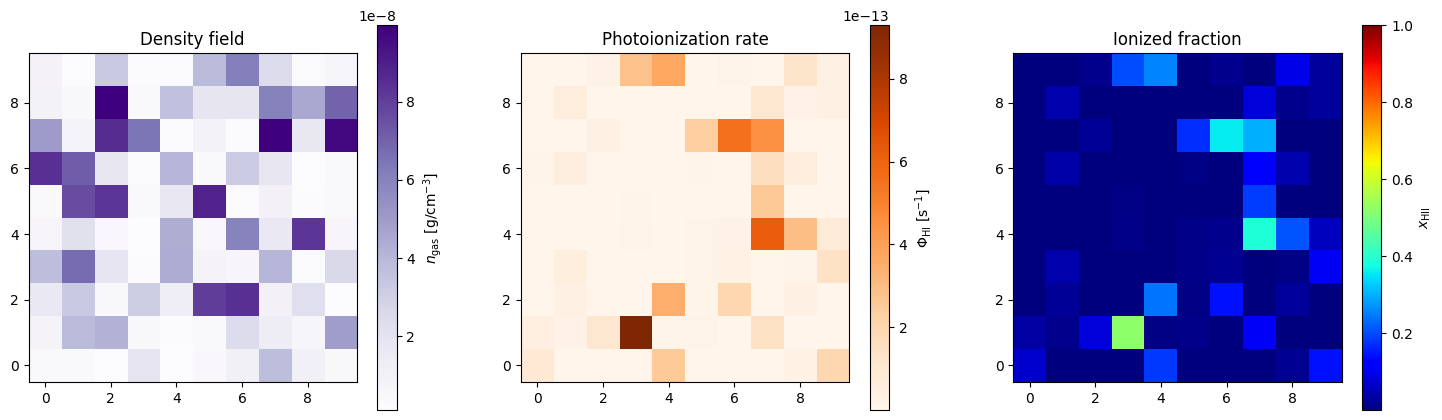

In [17]:
i_t = 500

fig, axs = plt.subplots(figsize=(18,5), ncols=3, nrows=1)
axs[0].set_title('Density field')
im = axs[0].imshow(ndens.reshape(10,10,10)[:,5,:], origin='lower', cmap='Purples')
plt.colorbar(im, ax=axs[0], label=r'$n_{\rm gas}$ [g/$\rm cm^{-3}$]')

axs[1].set_title('Photoionization rate')
im = axs[1].imshow(phi_ion.reshape(10,10,10)[:,5,:], origin='lower', cmap='Oranges')
plt.colorbar(im, ax=axs[1], label=r'$\Phi_{\rm HI}$ [$\rm s^{-1}$]')

axs[2].set_title('Ionized fraction')
im = axs[2].imshow(data[i_t].reshape(10,10,10)[:,5,:], origin='lower', cmap='jet', vmin=1e-5, vmax=1)
plt.colorbar(im, ax=axs[2], label=r'$x_{\rm HII}$')
plt.show()